In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import scipy as sp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [4]:
#loading simulated data
p_sim = sp.sparse.load_npz('../../data/tilt/20x20x20/pDisc_40000_20x20x20_tilt_largeEvts.npz')
C_sim = sp.sparse.load_npz('../../data/tilt/20x20x20/CDisc_40000_20x20x20_tilt_largeEvts.npz')
junk_sim = sp.sparse.load_npz('../../data/tilt/20x20x20/noiseDisc_40000_20x20x20.npz')

#loading real data
p_0130 = sp.sparse.load_npz('../../data/real/20x20x20/run_0130_pDisc.npz')
C_0130 = sp.sparse.load_npz('../../data/real/20x20x20/run_0130_CDisc.npz')
junk_0130 = sp.sparse.load_npz('../../data/real/20x20x20/run_0130_junkDisc.npz')
p_0210 = sp.sparse.load_npz('../../data/real/20x20x20/run_0210_pDisc.npz')
C_0210 = sp.sparse.load_npz('../../data/real/20x20x20/run_0210_CDisc.npz')
junk_0210 = sp.sparse.load_npz('../../data/real/20x20x20/run_0210_junkDisc.npz')

p_real = sp.sparse.vstack([p_0130, p_0210], format='csr')
C_real = sp.sparse.vstack([C_0130, C_0210], format='csr')
junk_real = sp.sparse.vstack([junk_0130, junk_0210], format='csr')

In [5]:
#creating labels
p_sim_labels = np.zeros((p_sim.shape[0],))
C_sim_labels = np.ones((C_sim.shape[0],))
junk_sim_labels = np.ones((junk_sim.shape[0],))

p_real_labels = np.zeros((p_real.shape[0],))
C_real_labels = np.ones((C_real.shape[0],))
junk_real_labels = np.ones((junk_real.shape[0],))

In [6]:
print("Simulated proton events: " + str(p_sim.shape[0]))
print("Simulated Carbon events: " + str(C_sim.shape[0]))
print("Simulated junk events: " + str(junk_sim.shape[0]))

print("Real proton events: " + str(p_real.shape[0]))
print("Real Carbon events: " + str(C_real.shape[0]))
print("Real junk events: " + str(junk_real.shape[0]))

Simulated proton events: 40001
Simulated Carbon events: 40001
Simulated junk events: 40000
Real proton events: 663
Real Carbon events: 340
Real junk events: 1686


# Predicting proton vs. Carbon (w/ Simulated Noise)

In [7]:
pC_sim = sp.sparse.vstack([p_sim, C_sim], format='csr')
pC_sim_labels = np.hstack((p_sim_labels, C_sim_labels))

pC_real = sp.sparse.vstack([p_real, C_real], format='csr')
pC_real_labels = np.hstack((p_real_labels, C_real_labels))

In [8]:
pC_sim_train, pC_sim_test, pC_sim_labels_train, pC_sim_labels_test = train_test_split(pC_sim, pC_sim_labels, test_size=0.25, random_state=42)

In [9]:
reg = 0.1
lr_pC = LogisticRegression(C=reg)
lr_pC.fit(pC_sim_train, pC_sim_labels_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
#train on simulated + test on simulated 
pC_sim_pred = lr_pC.predict(pC_sim_test)

print("Accuracy: " + str(metrics.accuracy_score(pC_sim_labels_test, pC_sim_pred)))
print(metrics.classification_report(pC_sim_labels_test, pC_sim_pred))
print(metrics.confusion_matrix(pC_sim_labels_test, pC_sim_pred))

Accuracy: 0.8769561521923904
             precision    recall  f1-score   support

        0.0       0.87      0.89      0.88     10007
        1.0       0.89      0.87      0.88      9994

avg / total       0.88      0.88      0.88     20001

[[8887 1120]
 [1341 8653]]


In [11]:
#train on simulated + test on real
pC_real_pred = lr_pC.predict(pC_real)

print("Accuracy: " + str(metrics.accuracy_score(pC_real_labels, pC_real_pred)))
print(metrics.classification_report(pC_real_labels, pC_real_pred))
print(metrics.confusion_matrix(pC_real_labels, pC_real_pred))

Accuracy: 0.5244267198404786
             precision    recall  f1-score   support

        0.0       0.96      0.29      0.45       663
        1.0       0.41      0.98      0.58       340

avg / total       0.78      0.52      0.49      1003

[[193 470]
 [  7 333]]


In [12]:
C_vals = [10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3]

precisions_sim = []
recalls_sim = []
f1s_sim = []
accuracies_sim = []

precisions_real = []
recalls_real = []
f1s_real = []
accuracies_real = []

for c in C_vals:
    pC_sim_pred = LogisticRegression(C=c).fit(pC_sim_train, pC_sim_labels_train).predict(pC_sim_test)
    
    precisions_sim.append(metrics.precision_score(pC_sim_labels_test, pC_sim_pred))
    recalls_sim.append(metrics.recall_score(pC_sim_labels_test, pC_sim_pred))
    f1s_sim.append(metrics.f1_score(pC_sim_labels_test, pC_sim_pred))
    accuracies_sim.append(metrics.accuracy_score(pC_sim_labels_test, pC_sim_pred))
    print("Simulated Data  C=" + str(c) + " accuracy=" + str(metrics.accuracy_score(pC_sim_labels_test, pC_sim_pred)))
    
    pC_real_pred = LogisticRegression(C=c).fit(pC_sim_train, pC_sim_labels_train).predict(pC_real)
    
    precisions_real.append(metrics.precision_score(pC_real_labels, pC_real_pred))
    recalls_real.append(metrics.recall_score(pC_real_labels, pC_real_pred))
    f1s_real.append(metrics.f1_score(pC_real_labels, pC_real_pred))
    accuracies_real.append(metrics.accuracy_score(pC_real_labels, pC_real_pred))
    print("Real Data       C=" + str(c) + " accuracy=" + str(metrics.accuracy_score(pC_real_labels, pC_real_pred)))

Simulated Data  C=1e-05 accuracy=0.7718614069296535
Real Data       C=1e-05 accuracy=0.3469591226321037
Simulated Data  C=0.0001 accuracy=0.8599570021498925
Real Data       C=0.0001 accuracy=0.3708873379860419
Simulated Data  C=0.001 accuracy=0.8865056747162642
Real Data       C=0.001 accuracy=0.43668993020937186
Simulated Data  C=0.01 accuracy=0.8867056647167642
Real Data       C=0.01 accuracy=0.5024925224327019
Simulated Data  C=0.1 accuracy=0.8769561521923904
Real Data       C=0.1 accuracy=0.5244267198404786
Simulated Data  C=1.0 accuracy=0.8736063196840158
Real Data       C=1.0 accuracy=0.5274177467597209
Simulated Data  C=10.0 accuracy=0.8728563571821409
Real Data       C=10.0 accuracy=0.5274177467597209
Simulated Data  C=100.0 accuracy=0.8728063596820159
Real Data       C=100.0 accuracy=0.5274177467597209
Simulated Data  C=1000.0 accuracy=0.8728063596820159
Real Data       C=1000.0 accuracy=0.5274177467597209
Simulated Data  C=10000.0 accuracy=0.8728063596820159
Real Data       C

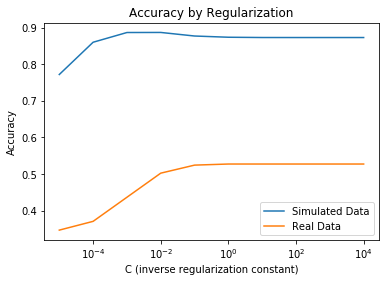

In [13]:
a = np.arange(len(C_vals))

plt.plot(C_vals, accuracies_sim)
plt.plot(C_vals, accuracies_real)

plt.xscale('log')
        
plt.xlabel('C (inverse regularization constant)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Regularization')
plt.legend(['Simulated Data', 'Real Data'], loc='lower right')

#plt.savefig('../../plots/results/real/LR_pC_accuracyxC.pdf')

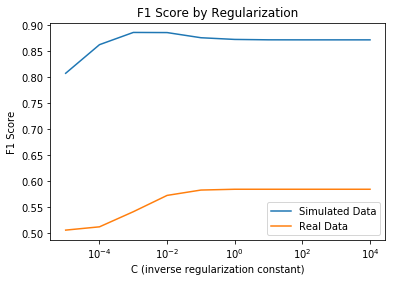

In [14]:
a = np.arange(len(C_vals))

plt.plot(C_vals, f1s_sim)
plt.plot(C_vals, f1s_real)

plt.xscale('log')
        
plt.xlabel('C (inverse regularization constant)')
plt.ylabel('F1 Score')
plt.title('F1 Score by Regularization')
plt.legend(['Simulated Data', 'Real Data'], loc='lower right')

#plt.savefig('')

# Predicting proton vs. Carbon + junk (w/ Simulated Noise)

In [15]:
# proton 0s
# Carbon+junk 1s
pCjunk_sim = sp.sparse.vstack([p_sim, C_sim, junk_sim], format='csr')
pCjunk_sim_labels = np.hstack((p_sim_labels, C_sim_labels, junk_sim_labels))

pCjunk_real = sp.sparse.vstack([p_real, C_real, junk_real], format='csr')
pCjunk_real_labels = np.hstack((p_real_labels, C_real_labels, junk_real_labels))

In [16]:
pCjunk_sim_train, pCjunk_sim_test, pCjunk_sim_labels_train, pCjunk_sim_labels_test = train_test_split(pCjunk_sim, pCjunk_sim_labels, test_size=0.25, random_state=42)

In [17]:
reg = 0.001
lr_pCjunk = LogisticRegression(C=reg)
lr_pCjunk.fit(pCjunk_sim_train, pCjunk_sim_labels_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
#train on simulated + test on simulated 
pCjunk_sim_pred = lr_pCjunk.predict(pCjunk_sim_test)

print("Accuracy: " + str(metrics.accuracy_score(pCjunk_sim_labels_test, pCjunk_sim_pred)))
print(metrics.classification_report(pCjunk_sim_labels_test, pCjunk_sim_pred))
print(metrics.confusion_matrix(pCjunk_sim_labels_test, pCjunk_sim_pred))

Accuracy: 0.6401119962667912
             precision    recall  f1-score   support

        0.0       0.42      0.20      0.27     10050
        1.0       0.68      0.86      0.76     19951

avg / total       0.59      0.64      0.60     30001

[[ 2001  8049]
 [ 2748 17203]]


In [19]:
#train on simulated + test on real 
pCjunk_real_pred = lr_pCjunk.predict(pCjunk_real)

print("Accuracy: " + str(metrics.accuracy_score(pCjunk_real_labels, pCjunk_real_pred)))
print(metrics.classification_report(pCjunk_real_labels, pCjunk_real_pred))
print(metrics.confusion_matrix(pCjunk_real_labels, pCjunk_real_pred))

print(pCjunk_real_pred.shape)
print(np.sum(pCjunk_real_pred))

Accuracy: 0.7753811825957605
             precision    recall  f1-score   support

        0.0       0.88      0.10      0.18       663
        1.0       0.77      1.00      0.87      2026

avg / total       0.80      0.78      0.70      2689

[[  68  595]
 [   9 2017]]
(2689,)
2612.0


# Predicting proton vs. Carbon vs. junk (w/ Simulated Noise) - **multi-class**

In [20]:
#protons 0
#carbons 1
#junk 2

#create junk 2s labels
junkMC_sim_labels = np.full(junk_sim_labels.shape, 2)
junkMC_real_labels = np.full(junk_real_labels.shape, 2)

multi_sim = sp.sparse.vstack([p_sim, C_sim, junk_sim], format='csr')
multi_sim_labels = np.hstack((p_sim_labels, C_sim_labels, junkMC_sim_labels))

multi_real = sp.sparse.vstack([p_real, C_real, junk_real], format='csr')
multi_real_labels = np.hstack((p_real_labels, C_real_labels, junkMC_real_labels))

In [21]:
print(multi_sim_labels.shape)
print(multi_real_labels.shape)

(120002,)
(2689,)


In [22]:
multi_sim_train, multi_sim_test, multi_sim_labels_train, multi_sim_labels_test = train_test_split(multi_sim, multi_sim_labels, test_size=0.25, random_state=42)

In [23]:
reg = 0.001
lr_multi = LogisticRegression(C=reg, multi_class='ovr')
lr_multi.fit(multi_sim_train, multi_sim_labels_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
#train on simulated + test on simulated 
multi_sim_pred = lr_multi.predict(multi_sim_test)

print("Accuracy: " + str(metrics.accuracy_score(multi_sim_labels_test, multi_sim_pred)))
print(metrics.classification_report(multi_sim_labels_test, multi_sim_pred))
print(metrics.confusion_matrix(multi_sim_labels_test, multi_sim_pred))

Accuracy: 0.7203759874670844
             precision    recall  f1-score   support

        0.0       0.65      0.44      0.53     10050
        1.0       0.84      0.91      0.87     10053
        2.0       0.66      0.80      0.72      9898

avg / total       0.71      0.72      0.71     30001

[[4466 1576 4008]
 [ 703 9191  159]
 [1741  202 7955]]


In [25]:
#train on simulated + test on simulated 
multi_real_pred = lr_multi.predict(multi_real)

print("Accuracy: " + str(metrics.accuracy_score(multi_real_labels, multi_real_pred)))
print(metrics.classification_report(multi_real_labels, multi_real_pred))
print(metrics.confusion_matrix(multi_real_labels, multi_real_pred))

Accuracy: 0.25957605057642247
             precision    recall  f1-score   support

        0.0       0.68      0.12      0.21       663
        1.0       0.15      0.98      0.26       340
        2.0       0.92      0.17      0.28      1686

avg / total       0.77      0.26      0.26      2689

[[  82  563   18]
 [   1  334    5]
 [  37 1367  282]]


# Predicting proton vs. junk (w/ Simulated Noise)

In [26]:
# proton 0s
# junk 1s
pjunk_sim = sp.sparse.vstack([p_sim, junk_sim], format='csr')
pjunk_sim_labels = np.hstack((p_sim_labels, junk_sim_labels))

pjunk_real = sp.sparse.vstack([p_real, junk_real], format='csr')
pjunk_real_labels = np.hstack((p_real_labels, junk_real_labels))

In [27]:
pjunk_sim_train, pjunk_sim_test, pjunk_sim_labels_train, pjunk_sim_labels_test = train_test_split(pjunk_sim, pjunk_sim_labels, test_size=0.25, random_state=42)

In [28]:
reg = 0.001
lr_pjunk = LogisticRegression(C=reg)
lr_pjunk.fit(pjunk_sim_train, pjunk_sim_labels_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
#train on simulated + test on simulated 
pjunk_sim_pred = lr_pjunk.predict(pjunk_sim_test)

print("Accuracy: " + str(metrics.accuracy_score(pjunk_sim_labels_test, pjunk_sim_pred)))
print(metrics.classification_report(pjunk_sim_labels_test, pjunk_sim_pred))
print(metrics.confusion_matrix(pjunk_sim_labels_test, pjunk_sim_pred))

Accuracy: 0.7340132993350332
             precision    recall  f1-score   support

        0.0       0.75      0.70      0.72     10002
        1.0       0.72      0.77      0.74      9999

avg / total       0.74      0.73      0.73     20001

[[6982 3020]
 [2300 7699]]


In [30]:
#train on simulated + test on real 
pjunk_real_pred = lr_pjunk.predict(pjunk_real)

print("Accuracy: " + str(metrics.accuracy_score(pjunk_real_labels, pjunk_real_pred)))
print(metrics.classification_report(pjunk_real_labels, pjunk_real_pred))
print(metrics.confusion_matrix(pjunk_real_labels, pjunk_real_pred))

Accuracy: 0.36441038739889314
             precision    recall  f1-score   support

        0.0       0.30      0.96      0.46       663
        1.0       0.90      0.13      0.23      1686

avg / total       0.73      0.36      0.29      2349

[[ 639   24]
 [1469  217]]
